<a href="https://colab.research.google.com/github/2SUBDA/Block2_Walk/blob/Week_4/Week4_TimeSeries_ARIMA_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
## SAMPLE TIME SERIES USING RETAIL DATA
## BASED ON MILLER (2015) and BROWNLEE (2016)

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox



In [14]:
# OBTAIN - MANY WAYS TO GET DATA - THIS IS ONE

series1 = pd.read_csv('https://raw.githubusercontent.com/2SUBDA/Block2_Walk/master/Dept1.csv', header=0,
                      index_col="Date", parse_dates=["Date"])

series1 = series1.sort_index()
series1.head()



,Sales,IsHoliday
Date,,
2010-02-05,24924.50,False
2010-02-12,46039.49,True
2010-02-19,41595.55,False
2010-02-26,19403.54,False
2010-03-05,21827.90,False


In [ ]:
# OBTAIN - MANY WAYS TO GET MORE DATA
# DEPT 25 IS BEVERAGE
# DEPT 80 IS SERVICE DELI / CHICKEN\
# DEPT 94 IS PRODUCE


series25 = pd.read_csv('https://raw.githubusercontent.com/2SUBDA/Block2_Walk/master/Dept25.csv', header=0,
                       index_col="Date", parse_dates=["Date"])
print(series25.describe())


series80 = pd.read_csv('https://raw.githubusercontent.com/2SUBDA/Block2_Walk/master/Dept80.csv', header=0,
                       index_col="Date", parse_dates=["Date"])
print(series80.describe())

# series94 = pd.read_csv('https://raw.githubusercontent.com/2SUBDA/Block2_Walk/master/Dept94.csv', header=0,
#                        index_col="Date", parse_dates=["Date"])
# print(series94.describe())

Text(0.5, 1.0, 'Dept 1 Sales from 2010ish to 2012ish')

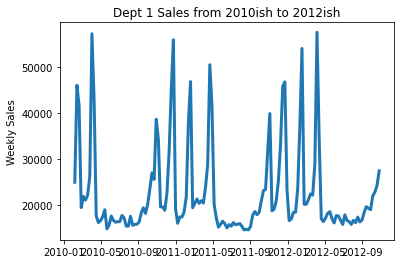

In [15]:
# EXPLORE - WHAT DOES THE DATA LOOK LIKE - IN A CHART?

fig, ax = plt.subplots()
ax.plot(series1['Sales'], linewidth=3)
ax.set_ylabel('Weekly Sales')
ax.set_title('Dept 1 Sales from 2010ish to 2012ish')

Text(0.5, 1.0, 'Holidays in the Time Series')

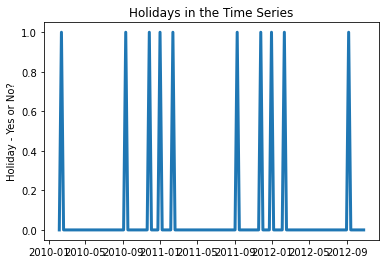

In [16]:
# EXPLORE - WHAT DOES THE DATA LOOK LIKE - WHAT ARE THESE HOLIDAYS?

fig, ax = plt.subplots()
ax.plot(series1['IsHoliday'], linewidth=3)
ax.set_ylabel('Holiday - Yes or No?')
ax.set_title('Holidays in the Time Series')


Additional EDA is left to the student :)

What plots might help us understand the data more?

Or is the basic time series plot enough?

In [19]:
# EXPLORE - IS OUR TIME SERIES STATIONARY OR NOT?

result = adfuller(series1['Sales'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.522164
p-value: 0.110174
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


ADF Statistic: -8.892005
p-value: 0.000000
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584


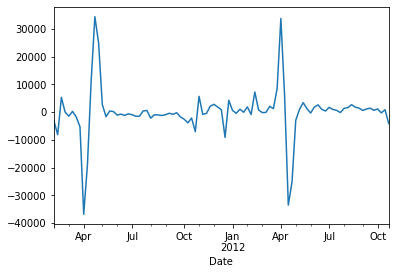

In [21]:
# SCRUB - OUR TIME SERIES IS NOT STATIONARY - WE NEED TO TAKE THE DIFFERENCE
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)


X = series1['Sales']
X = X.astype('float32')
# difference data
weeks_in_year = 52
stationary = difference(X, weeks_in_year)
stationary.index = series1.index[weeks_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()


The first differenced series1 is stationary - now we can explore some models.

In [22]:
# SCRUB - SOME CODE TO INVERT DIFFERENCE VALUE

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

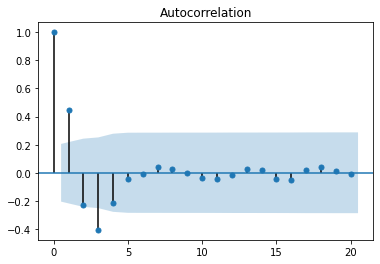

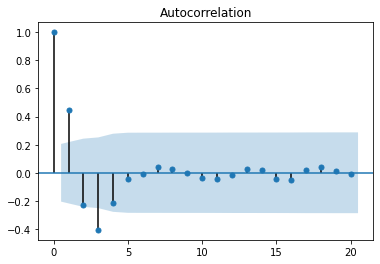

In [31]:
# USING STATIONARY TIME SERIES LOOK AT ACF

series = stationary

plot_acf(series)


Depicts some minor seasonality in PACF still

Starting point for **ARIMA** could be 2,1,3 (or 2,1,1)

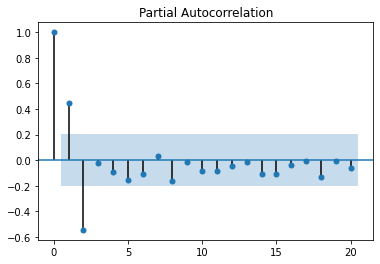

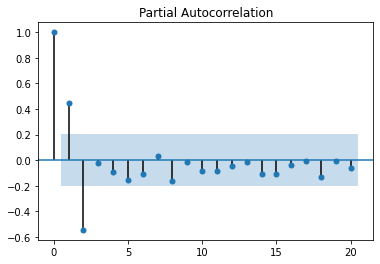

In [30]:
# USING STATIONARY TIME SERIES LOOK FOR PACF

plot_pacf(series)


In [32]:
# BUILD THE MODEL - USING ORIGINAL SERIES1 DATA

# prepare data
X = series1['Sales']
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=16111.646, Expected=14978
>Predicted=14791.484, Expected=15683
>Predicted=16067.750, Expected=15364
>Predicted=16370.879, Expected=16149
>Predicted=15580.162, Expected=15655
>Predicted=14122.381, Expected=15767
>Predicted=16335.969, Expected=15922
>Predicted=17266.652, Expected=15296
>Predicted=12442.037, Expected=14540
>Predicted=16304.131, Expected=14689
>Predicted=14197.763, Expected=14537
>Predicted=14947.763, Expected=15277
>Predicted=17407.034, Expected=17747
>Predicted=18932.359, Expected=18535
>Predicted=16966.564, Expected=17859
>Predicted=20159.738, Expected=18338
>Predicted=20941.320, Expected=20798
>Predicted=24796.508, Expected=23078
>Predicted=21617.366, Expected=23352
>Predicted=37539.425, Expected=31580
>Predicted=24987.213, Expected=39886
>Predicted=30742.259, Expected=18690
>Predicted=12110.125, Expected=19051
>Predicted=20839.454, Expected=20911
>Predicted=25025.422, Expected=25293
>Predicted=33442.430, Expected=33306
>Predicted=46256.516, Expected=45773
>

Okay - not bad - RMSE of 7271 - but we might be able to do better - how can conduct a review of all possible combinations of ARIMA models?

In [34]:
# CODE RUNS LONG FOR EVALUATION - approximately 34 mins on COLAB
import warnings
import numpy
  
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		weeks_in_year = 52
		diff = difference(history, weeks_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, weeks_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# LOAD DATA

series = series1['Sales']
# evaluate parameters
p_values = range(0, 9)
d_values = range(0, 3)
q_values = range(0, 9)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=5988.700
ARIMA(0, 1, 1) RMSE=8443.946
ARIMA(0, 1, 2) RMSE=6087.678
ARIMA(0, 1, 3) RMSE=7249.182
ARIMA(0, 2, 1) RMSE=7823.737
ARIMA(0, 2, 2) RMSE=8433.167
ARIMA(1, 0, 0) RMSE=6539.042
ARIMA(1, 0, 1) RMSE=6137.660
ARIMA(1, 0, 2) RMSE=6509.124
ARIMA(1, 0, 3) RMSE=6487.354
ARIMA(1, 0, 4) RMSE=6438.131
ARIMA(1, 1, 0) RMSE=8161.451
ARIMA(1, 1, 1) RMSE=6785.036
ARIMA(1, 2, 0) RMSE=10899.965
ARIMA(2, 0, 0) RMSE=5920.841
ARIMA(2, 0, 1) RMSE=5982.551
ARIMA(2, 0, 2) RMSE=6435.549
ARIMA(2, 0, 3) RMSE=6773.749
ARIMA(2, 0, 4) RMSE=6931.470
ARIMA(2, 1, 0) RMSE=7271.052
ARIMA(2, 1, 1) RMSE=6027.573
ARIMA(2, 2, 0) RMSE=9785.715
ARIMA(3, 0, 0) RMSE=6012.409
ARIMA(3, 0, 1) RMSE=5932.013
ARIMA(3, 1, 0) RMSE=7265.131
ARIMA(3, 2, 0) RMSE=9432.910
ARIMA(4, 0, 0) RMSE=6016.021
ARIMA(4, 0, 1) RMSE=6000.121
ARIMA(4, 1, 0) RMSE=7151.360
ARIMA(4, 2, 0) RMSE=9153.688
ARIMA(5, 0, 0) RMSE=6065.362
ARIMA(5, 0, 1) RMSE=6041.892
ARIMA(5, 1, 0) RMSE=6961.144
ARIMA(5, 2, 0) RMSE=8915.556
ARIMA(6, 0, 0

                  0
count     72.000000
mean    -120.713087
std     5961.151646
min   -22349.369043
25%    -1123.692264
50%      293.717131
75%     1455.023319
max    28390.581631
RMSE: 5920.841


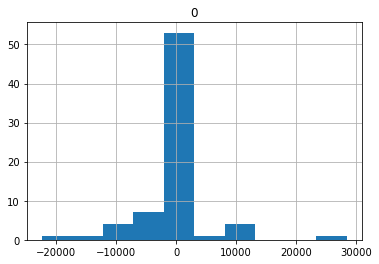

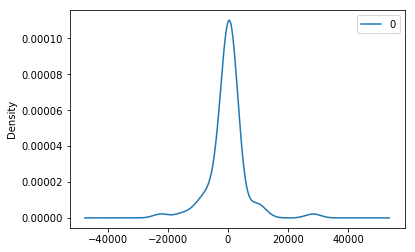

In [ ]:
#@title
# SIMILAR BLOCK OF CODE - THIS ONE SAVES RESIDUALS FOR PLOTTING

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = Series.from_csv('data/Dept1.csv', header=0)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(2,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=pyplot.gca())
pyplot.show()

residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

                  0
count  7.200000e+01
mean  -1.502562e-07
std    5.961152e+03
min   -2.222866e+04
25%   -1.002979e+03
50%    4.144302e+02
75%    1.575736e+03
max    2.851129e+04
RMSE: 5919.610


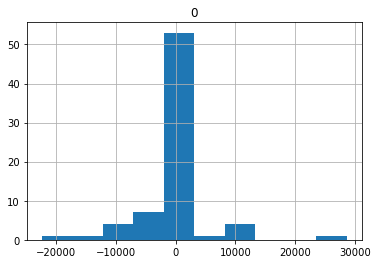

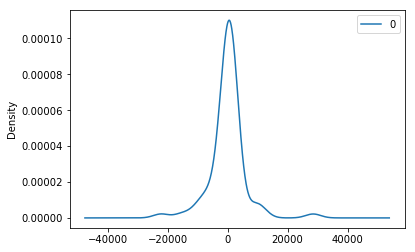

In [ ]:
#@title
## RECREATE ANALYSIS WITH MEAN RESIDUAL ADDED TO EACH PREDICTION
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = Series.from_csv('data/Dept1.csv', header=0)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -120.713087
for i in range(len(test)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(2,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=pyplot.gca())
pyplot.show()

residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

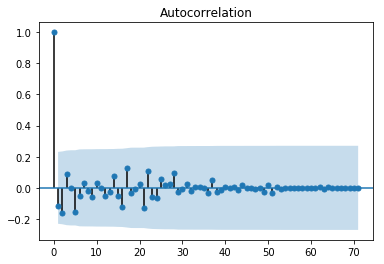

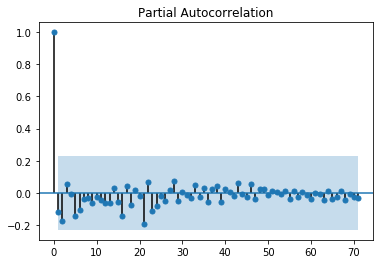

In [ ]:
# LOOK AT ACF AND PACF FOR RESIDUALS
plot_acf(residuals, ax=pyplot.gca())
pyplot.show()

plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [ ]:
#@title
## CODE FROM BROWNLEE FOR SAVING MODEL

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# prepare data
X = series1['Sales']
X = X.astype('float32')
# difference data
weeks_in_year = 52
diff = difference(X, weeks_in_year)
# fit model
model = ARIMA(diff, order=(2,0,0))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual - CHANGED TO ZERO
bias = 0
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])


In [ ]:
#@title
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING ONE STEP AHEAD

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = series1['Sales']
weeks_in_year = 52
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, weeks_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 36609.784


>Predicted=12019.274, Expected=16120
>Predicted=15207.165, Expected=17331
>Predicted=16164.121, Expected=16286
>Predicted=14142.675, Expected=16680
>Predicted=15896.584, Expected=18322
>Predicted=18696.761, Expected=19616
>Predicted=18197.117, Expected=19252
>Predicted=17355.204, Expected=18948
>Predicted=18705.058, Expected=21904
>Predicted=22673.358, Expected=22764
>Predicted=22530.734, Expected=24185
>Predicted=23068.027, Expected=27391
RMSE: 2412.213


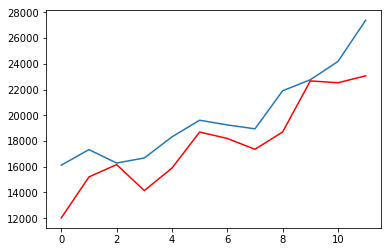

In [ ]:
#@title
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD
# NEED VALIDATION FILE FROM BELOW


def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = series1['Sales']
X = dataset.values.astype('float32')
history = [x for x in X]
weeks_in_year = 52
validation = Series.from_csv('data/validation.csv', header=0)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, weeks_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(2,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

Following functions provide for creating test & train | differenced series | inverse of difference

In [ ]:
# CREATE TRAIN-TEST DATA
# DATA IS WEEKLY FOR 2+ years
# KEEP ONE QUARTER - 13 weeks - AS THE TEST DATA
series = Series.from_csv('data/Dept1.csv', header=0)
split_point = len(series) - 13
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('data/dataset.csv')
validation.to_csv('data/validation.csv')

Dataset 130, Validation 13


In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff



In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]